In [1]:
"""--------------------------------------------------------------------------
This script analyzes and classifies environmental indicators (noise pollution, green space supply, brigtness temperature) 
and indicators of social status to assess environmental justice at city level. Spatial level of analysis are districts.
The code create maps and plots to visualize the results of the analysis. The results and visual outputs are saved to the 
"output" folder
------------------------------------------------------------------------------"""

'--------------------------------------------------------------------------\nThis script analyzes and classifies environmental indicators (noise pollution, green space supply, brigtness temperature) \nand indicators of social status to assess environmental justice at city level. Spatial level of analysis are districts.\nThe code create maps and plots to visualize the results of the analysis. The results and visual outputs are saved to the \n"output" folder\n------------------------------------------------------------------------------'

#### import libraries

In [2]:
import geopandas as gpd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import cartopy.crs as ccrs
import pandas as pd
from scipy.stats import zscore
import contextily as cx


In [3]:
#makes plot interactive
plt.ion()

In [4]:
# loads all of the required data to calculate the social indicator
admin = gpd.read_file("data/Stadtteile_Hamburg.shp") # boundary dataset 
stats = pd.read_csv("data/statistics_HH21.csv",encoding="utf-8", delimiter=";",decimal="." ) # social statistics

# loads all of the required data to calculate the environmental indicators
noise = gpd.read_file("data/Laermkarten_HH_2018-11-19.shp") #noise data set
buildings = gpd.read_file('data/residential_buildings_HH.shp') #building dataset
green_areas = gpd.read_file("data/Oeffentliche_Gruenanlage_Hamburg.shp") #green areas dataset
brightnesstemp =pd.read_csv("data/temp_stats.csv",encoding="utf-8", delimiter=";",decimal="," ) # temperature data

#### Functions used in the script

In [5]:
"""------- Function to reproject the datasets----------------"""
def reproject_to_local_epsg(gdf):
    """ Reprojects the dataframe to epsg=25832 for Hamburg. EPSG 25832
    
    Input: dataframe
    
    Returns:
    A dataframe, reprojected to the target crs as specified in the function
    Prints out the crs of the original and of the  crs of the reprojection

    """
    print('Original CRS:', gdf.crs)

    gdf_reproj = gdf.to_crs(epsg=25832)    # Reprojects the GeoDataFrame to EPSG 25832
    print('Reprojected CRS:', gdf_reproj.crs)

    return gdf_reproj

In [6]:
"""------------------------- Function to classify the indicators-----------------------"""

def percentile_5(gpd, col_name, percentiles): # used for all environmental indicators / indicators taking 1 column as input
    """Classifies the dataframe into 5 equal percentiles 

    Parameters: 
        gpd : geodataframe 
        col_name: column of indicator used for classification
        percentiles : number of quantiles used for classification "5" : MUST be the same length as the labels
        labels: values resulting from the classification from 0-4 (e.g. 0= lowest 20th quantile of mean / to 4 within highest 20th quantile)
        
    Returns: 
    A classified geodataframe that saves the results of the classification in a new column with the name extension _percentile. 
    The new column contains the values from 0-4
    
    Apply the function: 
    Example: percentile_5(dataframe, 'columName',5)"""   
    
    gpd[col_name + '_percentile']  = pd.qcut(gpd[col_name], percentiles, labels=[0, 1, 2, 3, 4]) 

    return gpd


In [7]:
"""-----Function to classify the dataframe for use of multiple columns--- """

def percentile_multi(gdf, col_names, percentiles): # used for social inidator in this code
    """Classifies the dataframe into 5 equal percentiles. Takes as input multiple columns and the sum of these
    
    Parameters:
        gdf: geodataframes with the columns used for classification
        col_names: colums used for classification
        percentiles: number of percentiles used for classification
        labels: values resulting from classification 0-4 (same as for "function percentile_5")
    
    Returns:
        A dataframe which saves the results of the classification by percentiles into a new column called "qt_soc_stats"
        The new column contains the values from 0-4 and constitutes the sum of colums used for calculation
        
    Apply the function:
        Example: percentile_multi(dataframe, ['col1', 'col2'], 5)
    """
    sum_col = gdf[col_names].sum(axis=1)
    gdf['qt_soc_stats'] = pd.qcut(sum_col, percentiles, labels=[0, 1, 2, 3, 4])
    return gdf.head()


In [8]:
"""-----Function to add a status column  --- """

def add_status_column(df, perc_col): #The function will be used for all of the different indicators)
    """The function adds a text column to the dataframe. The value of the text column is assigned based
        on the values of the classified "_percentile column"

    Parameters: 
        df : dataframe used for the classification
        perc_col: Column used to assign te the text values: NEEDS to be a categorial variable, resulting from the 
        "percentile functions" Has to take the classified column:result of func percentile as input
        
    Returns:
        A dataframe with a new column called "status" containing strings with the values from "very low" to "very high"
        Assignes the names based on the values in the perc_col
        
    Apply the functin:
        Example: add_status_column(dataframe, 'columnName') # 

    """
    df['status'] = ['very low' if x == 0 else  #creates the new column "status and then adds text description to the corresponding value"
                   'low' if x == 1 else
                   'medium' if x == 2 else
                   'high' if x == 3 else
                   'very high' for x in df[perc_col]]

    return df.head()


In [9]:
"""-----Function to create map--------------- """

# function to define parameters for mapping of indicators
def plot_stats(gdf, title, color,output_path):   
    """ The function creates a map to visualize the ranking of each classified indicator
    
    Parameters: 
        gdf : dataframe used for the map
        title: title to be displayed on the map
        color: allows the user to specify the colors used for visualization
        output_path: output_path to save the map with unique name 
        
        IMPORTANT: gdf for plotting has to contain a categorial column called "status"
        
    Returns:
        A cloropleth map visualizing the ranking of each district by percentile which is the result of the classification
        The map uses the "status" column representing the result of the classification for each indicator
        The percentile ranking is ordered in ascending order from very low to very high  
        The map displays a legend, basemap and allows distinct colormaps and titles based on the input parameters
        The map is automatically saved in png format
        
    Apply the functin:
        Example: plot_stats(your gdf,"title goes here", "color", "output_path")

    """    
    status_order = ['very low', 'low', 'medium', 'high', 'very high'] # order used for plotting

    # convert the status column to a categorical variable with the defined order
    gdf['status'] = pd.Categorical(gdf['status'], categories=status_order, ordered=True) 

    # sort the values
    gdf = gdf.sort_values('status')
    
    # Create a figure and define the size 
    fig, ax = plt.subplots(figsize=(12, 10))

    # Plotsthe data using the status column 
    gdf.plot("status", cmap=color, legend=True, ax=ax) 
    
    legend = ax.get_legend()
    legend.set_title("Percentile Ranking") # add the legend title
        
    #Set the title and style 
    ax.set_title(title, fontweight="bold", fontsize=14, color="#444444")
    
    #add basemap
    cx.add_basemap(ax,source=cx.providers.Stamen.TonerLite)
    
    

    #add the district name to the map polygons and define some style parameters
    gdf.apply(lambda x: ax.annotate(text=x['district'], xy=x.geometry.centroid.coords[0], ha='center', color="grey", size=7), axis=1)

    ax.set_axis_off()
    
    fig.savefig(output_path, dpi=300)

    # Display the plot
    plt.show()

# 1)  Social Indicator
Clean and filter the data 

In [10]:
#translate columns to English
stats.columns = ['district','inhabitants', 'pop<18','%<18', 'pop>65y','%>65', 'foreignResidents', 'migration_backg', 'hh','pp_size','hh_kids', '%hh_kids','areakm2', 'pop_density','working_pop', '%working_pop', 'unemployed','%unemployed','unemployed<18','%unemployed<18', 'unemployed>65', '%unemployed>65','social_benefits', '%social_benefits','social_housing', '%social_housing']

In [11]:
#join the csv file with the statistics with the shapefile of administrative boundaries 
admin_pop = pd.merge(admin,stats, left_on='stadtteil_', right_on='district', how = 'inner')
# drop unecessary columns in the admin dataset
admin_pop.drop(columns=['OBJECTID','bezirk', 'stadttei_1', 'stadttei_2','pp_size', '%<18', 'hh','foreignResidents', 'migration_backg','pop<18','hh_kids', '%hh_kids', 'pop>65y', 'unemployed<18','unemployed>65','working_pop', 'social_benefits','social_housing' ],axis=1, inplace=True)

In [12]:
# Subset the dataframe so that only columns relevant to the further analysis (social status) are maintained
# NULL values are droppped to enable calculation
social_stats = admin_pop[['%unemployed','%social_benefits','%social_housing','%unemployed>65' ]].dropna()
#code then checks standard deviation 
social_stats.std()

%unemployed          2.460547
%social_benefits     7.030869
%social_housing     11.185547
%unemployed>65       2.465196
dtype: float64

In [13]:
# Use Scipy Library to calculate the z-score to normalize values  
z_scores_admin_pop = social_stats[['%unemployed','%social_benefits','%social_housing','%unemployed>65']].apply(zscore)
print(z_scores_admin_pop.std()) # show the std after calculation of z-score

%unemployed         1.00554
%social_benefits    1.00554
%social_housing     1.00554
%unemployed>65      1.00554
dtype: float64


#### Classification of social statistics 

In [14]:
# apply the "percentile_multi" function to classify the data using on the results of the z_score calculation
percentile_multi(z_scores_admin_pop, ['%unemployed', '%social_benefits', '%social_housing', '%unemployed>65'], 5);

In [15]:
# apply the "add_status_column" function to add the status in text format
add_status_column(z_scores_admin_pop, 'qt_soc_stats') 

,%unemployed,%social_benefits,%social_housing,%unemployed>65,qt_soc_stats,status
0,0.059728,-0.115829,0.336371,0.061857,3,high
1,-0.839336,-0.587788,1.460075,-1.161827,1,low
2,0.018861,-0.258847,0.354350,0.388172,3,high
3,1.081391,0.484846,0.273443,2.101330,4,very high
4,0.141461,-0.244545,0.408288,0.592120,3,high


In [16]:
#rename the newly calculated columns to differentiate from columns of original dataset
z_scores_admin_pop.columns = ['%unemployed_z','%social_benefits_z', '%social_housing_z','%unemployed>65_z','qt_soc_stats', 'status']

In [17]:
#merge the social statistics to the admin dataframe to be able to plot  data later 
admin_socstats = pd.merge(admin_pop, z_scores_admin_pop, left_index=True, right_index=True) 
#drop the column with the "old statistics"
admin_socstats.drop(columns=['%unemployed','%social_benefits','%social_housing','%unemployed>65']);

In [18]:
admin_socstats.head()

,bezirk_nam,stadtteil_,SHAPE_Leng,SHAPE_Area,Bevölkeru,Arbeitslos,Bevölke_1,Arbeitsl_1,geometry,district,...,%unemployed<18,%unemployed>65,%social_benefits,%social_housing,%unemployed_z,%social_benefits_z,%social_housing_z,%unemployed>65_z,qt_soc_stats,status
0,Hamburg-Mitte,Hamburg-Altstadt,9028.180532,3.676562e+06,NaN,NaN,NaN,NaN,"POLYGON ((1113865.821 7085107.333, 1113978.324...",Hamburg-Altstadt,...,NaN,5.7,8.2,12.4,0.059728,-0.115829,0.336371,0.061857,3,high
1,Hamburg-Mitte,HafenCity,13902.691334,6.860720e+06,NaN,NaN,NaN,NaN,"POLYGON ((1113043.882 7082944.386, 1112901.932...",HafenCity,...,NaN,2.7,4.9,24.9,-0.839336,-0.587788,1.460075,-1.161827,1,low
2,Hamburg-Mitte,Neustadt,11133.923114,6.395226e+06,NaN,NaN,NaN,NaN,"POLYGON ((1112508.476 7085835.161, 1112319.283...",Neustadt,...,2.9,6.5,7.2,12.6,0.018861,-0.258847,0.354350,0.388172,3,high
3,Hamburg-Mitte,St. Pauli,15968.675123,6.343533e+06,NaN,NaN,NaN,NaN,"POLYGON ((1109116.549 7084327.397, 1109001.027...",St. Pauli,...,3.4,10.7,12.4,11.7,1.081391,0.484846,0.273443,2.101330,4,very high
4,Hamburg-Mitte,St. Georg,9795.650670,5.155061e+06,NaN,NaN,NaN,NaN,"POLYGON ((1114563.830 7085359.663, 1114541.839...",St. Georg,...,2.8,7.0,7.3,13.2,0.141461,-0.244545,0.408288,0.592120,3,high


# 2) Environmental Indicators
As environmental indicator the script calculates: noise burden, green area supply, surface temperature

In [19]:
# apply "reproject_to_local_epsg" function to all the dataframes to convert to same target CRS
admin_pop_reproj = reproject_to_local_epsg(admin_pop)
noise_reproj = reproject_to_local_epsg(noise)
housing_reproj = reproject_to_local_epsg(buildings)
green_areas_reproj = reproject_to_local_epsg(green_areas)
boundaries_reproj = reproject_to_local_epsg(admin)

Original CRS: EPSG:3857
Reprojected CRS: EPSG:25832
Original CRS: EPSG:25832
Reprojected CRS: EPSG:25832
Original CRS: EPSG:3857
Reprojected CRS: EPSG:25832
Original CRS: EPSG:3857
Reprojected CRS: EPSG:25832
Original CRS: EPSG:3857
Reprojected CRS: EPSG:25832


## a)  Green areas supply and spatial distribution
Analyzes distribution of green areas per district and area / inhabitant

In [20]:
#delete  values with code 10 = playground according to ALKIS key(official cadastre information system)
green_areas_reproj = green_areas_reproj[green_areas_reproj.nutzung != 10] # nutzung = usage
#drop unimportant columns from the dataset
green_areas_reproj.drop(columns=['dgpkey', 'veroeffent','gemarkung', 'ortsteil', 'nutzung', 'nutz_code' ,'herrichtun', 'verwaltung','flaeche_qm', 'gesamtanla','aktualitae','idnr','belegenh_1','belegenhei','quelle_dat', 'stand'],axis=1, inplace=True)

#### Calculation of statistics of green areas

In [21]:
boundaries_reproj.columns

Index(['OBJECTID', 'bezirk', 'bezirk_nam', 'stadtteil_', 'stadttei_1',
       'stadttei_2', 'SHAPE_Leng', 'SHAPE_Area', 'Bevölkeru', 'Arbeitslos',
       'Bevölke_1', 'Arbeitsl_1', 'geometry'],
      dtype='object')

In [22]:
# Calculate the sum of the area  statistics for green areas per district (district = stadtteil)
green_area_sum = green_areas_reproj.groupby(['stadtteil'])['flaeche_ha'].sum().reset_index() # group the dataset
green_area_sum.rename(columns={'flaeche_ha': 'green_area_total_ha'}, inplace=True) # translate column name to English

# Calculate mean green space area per district
green_area_mean = green_areas_reproj.groupby(['stadtteil'])['flaeche_ha'].mean().reset_index() 
green_area_mean.rename(columns={'flaeche_ha': 'green_area_mean_ha'}, inplace=True)

# Calculate the count of green spaces per district = "bennenung" = unique name of green area
green_space_count = green_areas_reproj.groupby(['stadtteil'])['benennung'].count().reset_index()
green_space_count.rename(columns={'benennung': 'green_space_count'}, inplace=True)

# Combine the statistics into one dataframe using the stadtteil column
green_stats = pd.merge(green_area_sum, green_area_mean, on='stadtteil')
green_stats = pd.merge(green_stats, green_space_count, on='stadtteil')


In [23]:
# Calculate the percentage of green space from total area of the district: "flaeche_ha" = area of individual polygons
green_stats['perc_green_area'] = green_areas_reproj['flaeche_ha'] / green_areas_reproj['geometry'].area * 100;

In [24]:
# merge with admin data to access information on inhabitants per district
green_stats = green_stats.merge(admin_pop_reproj[['stadtteil_', 'inhabitants']], left_on='stadtteil', right_on='stadtteil_', how='left')

In [25]:
#calculate area / inhabitant and save the results in a new column
green_stats['area_per_inhbt'] = green_stats['inhabitants'] / green_stats['green_area_total_ha']
green_stats.head()

,stadtteil,green_area_total_ha,green_area_mean_ha,green_space_count,perc_green_area,stadtteil_,inhabitants,area_per_inhbt
0,Allermöhe,41.4007,3.450058,7,0.010000,Allermöhe,1441.0,34.806175
1,Alsterdorf,13.6286,0.592548,6,0.010001,Alsterdorf,14975.0,1098.792246
2,Altengamme,0.2130,0.213000,0,0.010002,Altengamme,2319.0,10887.323944
3,Altona-Altstadt,28.3002,0.496495,37,0.009993,Altona-Altstadt,29151.0,1030.063392
4,Altona-Nord,8.0044,0.470847,1,0.010012,Altona-Nord,25942.0,3240.967468


In [26]:
#check std of relevant values used for classification
green_stats[['area_per_inhbt','perc_green_area' ]].std()

area_per_inhbt     2537.650695
perc_green_area       0.000002
dtype: float64

In [27]:
#drop Null values 
green_stats = green_stats.dropna(subset=['area_per_inhbt'])
#compute  z-score for the variables used for calculation from the  green_stats data  
z_scores_green_stats = green_stats[['area_per_inhbt','perc_green_area' ]].apply(zscore)

#rename columns to distinguish from columns in original dataset
z_scores_green_stats = z_scores_green_stats.rename(columns={'area_per_inhbt': 'z_area_per_inhbt', 'perc_green_area': 'z_perc_green_area'})
#check the std after z-score has been applied
z_scores_green_stats[['z_area_per_inhbt','z_perc_green_area' ]].std()

z_area_per_inhbt     1.00542
z_perc_green_area    1.00542
dtype: float64

In [28]:
# Concatenate the original dataframe with the z-score dataframe
green_stats_zscore = pd.concat([green_stats, z_scores_green_stats], axis=1)
# drop  original column names: perc_green_area and _area_per_inhb
green_stats_zscore = green_stats_zscore.drop(['area_per_inhbt', 'perc_green_area'], axis=1)


#### Classification of green area statistics

In [29]:
#apply "percentile_5" function to classify the green_stats data into equal percentiles based on 'area_per_inhbt' column
percentile_5(green_stats_zscore, 'z_area_per_inhbt',5);

In [30]:
# apply "add_status_column" function using the classified "_percentile column"
add_status_column(green_stats_zscore, 'z_area_per_inhbt_percentile')

,stadtteil,green_area_total_ha,green_area_mean_ha,green_space_count,stadtteil_,inhabitants,z_area_per_inhbt,z_perc_green_area,z_area_per_inhbt_percentile,status
0,Allermöhe,41.4007,3.450058,7,Allermöhe,1441.0,-0.597497,0.295181,0,very low
1,Alsterdorf,13.6286,0.592548,6,Alsterdorf,14975.0,-0.175944,0.530797,3,high
2,Altengamme,0.2130,0.213000,0,Altengamme,2319.0,3.702283,0.853910,4,very high
3,Altona-Altstadt,28.3002,0.496495,37,Altona-Altstadt,29151.0,-0.203175,-2.694367,3,high
4,Altona-Nord,8.0044,0.470847,1,Altona-Nord,25942.0,0.672788,5.245037,4,very high


In [31]:
#merge statistics with a subset of the reprojected admin dataframe to enable ploting
admin_subset = admin_pop_reproj[['district', 'geometry']]

admin_greenstats = pd.merge(admin_subset, green_stats_zscore, left_index=True, right_index=True);


## b) Noise Pollution 
For the noise indicator the assessment aims to identify the area of houses affected by noise and noiseclass per district  

Analysis, filter and cleaning of the housing dataset

In [32]:
#drop uninmportant columns in the dataset
housing_reproj.drop(columns=['anzahlDerU', 'lageZurErd', 'dachart', 'SHAPE_Leng'],axis=1, inplace=True)

In [33]:
# use geopandas overlay method and interesect operation to determine where the noise layer intersects with the house layer 
houses_noise = gpd.overlay(housing_reproj, noise_reproj, how='intersection')

In [34]:
#translate column names to English
houses_noise = houses_noise.rename(columns={'name': 'noiseclass', 'anzahlDerO': 'floors', 'grundflaec':'house_area'})

In [35]:
# join the dataframe to the admin dataset to enable map creation 
admin_noisestats = gpd.sjoin(admin_pop_reproj, houses_noise)

#### Calculation of statistics

In [36]:
#group the dataset to get the number of houses per noiseclass and district
houses_noiseclass = admin_noisestats.groupby(['district', 'noiseclass'])['OBJECTID'].count().reset_index()
houses_noiseclass.head()

,district,noiseclass,OBJECTID
0,Allermöhe,0,135
1,Allermöhe,1,281
2,Allermöhe,2,120
3,Allermöhe,3,25
4,Allermöhe,4,1


In [37]:
# mulitply the number of houses with the house area 
admin_noisestats['total_area'] = admin_noisestats['OBJECTID'] * admin_noisestats['house_area']

In [38]:
# multiply the house area with the number of floors to get the total affected residential housing area by noiseclass
#convert it to sqkm
admin_noisestats['area_floors']=admin_noisestats['total_area']*admin_noisestats['floors'].astype(int)/1000000

In [39]:
# convert the noiseclass to an integer
admin_noisestats['noiseclass'] = admin_noisestats['noiseclass'].astype(int)

In [40]:
#weight the area by noiseclass in view of severity from low to high (increase by 0.5)
weights = {0: 0.5, 1: 1, 2: 1.5, 3: 2, 4: 2.5} # dictionary to define the weights
#use the pandas.map function to assign the weights and saves results in new column
admin_noisestats['weighted_area'] = admin_noisestats['area_floors'] * admin_noisestats['noiseclass'].map(weights) 

#### Classification of noise statistics 

In [41]:
#group data by district and weighted area
noisestats_weighted = admin_noisestats.groupby('district')['weighted_area'].sum().reset_index()
#admin_noisestats.head() # recommended to not display the output due to its size

In [42]:
#apply the "percentile_5" function to classify the weigthed area column in percentiles
percentile_5(noisestats_weighted, 'weighted_area',5);

In [43]:
# apply the "add_status_column" function
add_status_column(noisestats_weighted, 'weighted_area_percentile')


,district,weighted_area,weighted_area_percentile,status
0,Allermöhe,5680.729861,0,very low
1,Alsterdorf,557766.168577,4,very high
2,Altengamme,3185.706718,0,very low
3,Altona-Altstadt,244193.273686,3,high
4,Altona-Nord,330024.822920,3,high


In [44]:
#merge the noise statistics  with a subset of the reprojected admin data to plot later
noisestats_merged = pd.merge(admin_subset, noisestats_weighted, left_index=True, right_index=True)
noisestats_merged.rename(columns={'district_x': 'district'}, inplace=True)
noisestats_merged.drop('district_y', axis=1, inplace=True)

## C) Brigthness Temperature

In [45]:
#join the statistics with the shapefile of administrative boundaries 
temp_bounds = pd.merge(boundaries_reproj,brightnesstemp, on="stadtteil_")

#### Classification of temperature brightness data

In [46]:
#apply "percentile_5" function to classify MEDIAN column into percentiles
percentile_5(temp_bounds, 'MEDIAN',5);

In [47]:
# apply the "add_status_column" function on the output of percentile_5 function to add text description
add_status_column(temp_bounds, 'MEDIAN_percentile');

In [48]:
#rename district column for use in the plotting function 
temp_bounds=temp_bounds.rename(columns={"stadtteil_":"district"})

In [49]:
temp_bounds.head()

,OBJECTID,bezirk,bezirk_nam,district,stadttei_1,stadttei_2,SHAPE_Leng,SHAPE_Area,Bevölkeru,Arbeitslos,...,MIN,MAX,RANGE,MEAN,STD,SUM,MEDIAN,PCT90,MEDIAN_percentile,status
0,1,1,Hamburg-Mitte,Hamburg-Altstadt,02101,101,9028.180532,3.676562e+06,NaN,NaN,...,23.668701,34.360291,10.691589,30.889566,1.849191,44511.863953,31.370575,32.559357,4,very high
1,2,1,Hamburg-Mitte,HafenCity,02102,102,13902.691334,6.860720e+06,NaN,NaN,...,22.602081,34.152863,11.550781,28.179191,2.662624,76027.458344,28.833740,31.015308,1,low
2,3,1,Hamburg-Mitte,Neustadt,02103,103,11133.923114,6.395226e+06,NaN,NaN,...,22.655518,33.157318,10.501801,29.914954,2.303340,75146.363708,30.601608,32.068347,3,high
3,4,1,Hamburg-Mitte,St. Pauli,02104,104,15968.675123,6.343533e+06,NaN,NaN,...,19.954590,37.018188,17.063599,30.616381,2.762301,76173.555511,31.357025,32.999854,4,very high
4,5,1,Hamburg-Mitte,St. Georg,02105,105,9795.650670,5.155061e+06,NaN,NaN,...,22.949036,37.309448,14.360413,29.882422,3.536494,60511.904449,31.347992,32.971094,4,very high


# 3) Combined Analysis of Individual Indicators
This section combines the indicators to assess the spatial relation between the individual indicators

In [50]:
#prepare for merge: subset the social stats dataset to keep only relevant columns for merge
soc_subset = admin_socstats[["bezirk_nam","district","geometry", "status","qt_soc_stats", "%unemployed","%social_benefits","%social_housing"]]
#rename status columns in all dataframes to avoid duplications 
soc_subset=soc_subset.rename(columns={"status":"status_soc"})
green_subset=green_stats_zscore.rename(columns={"status":"status_greens"})
noisestats_subset=noisestats_merged.rename(columns={"status":"status_noise"})
noisestats_subset.drop(columns=['geometry']);
tempstats_subset=temp_bounds.rename(columns={"status":"status_temp_b"})
tempstats_subset.drop(columns=['PCT90','RANGE']);

In [51]:
#merge the statistics data set to have one single dataframe for relevant statistics as output
stats_merged = green_subset.merge(soc_subset, left_on='stadtteil', right_on='district', how='inner')
stats_merged = stats_merged.merge(noisestats_subset, left_on='district', right_on='district', how='right');
stats_merged = stats_merged.merge(tempstats_subset, left_on='district', right_on='district', how='right');

In [52]:
#subset dataframe to keep only the ouput of the classification
stat_indicators=stats_merged[['district','weighted_area_percentile','z_area_per_inhbt_percentile','qt_soc_stats','status_greens','status_noise','MEDIAN_percentile','status_temp_b']]

In [53]:
#check data type of columns
print(stat_indicators[['district','weighted_area_percentile', 'z_area_per_inhbt_percentile', 'qt_soc_stats','MEDIAN_percentile']].dtypes)

district                         object
weighted_area_percentile       category
z_area_per_inhbt_percentile    category
qt_soc_stats                   category
MEDIAN_percentile              category
dtype: object


In [54]:
#create copy of data 
stat_indicators_copy = stat_indicators.copy()

In [55]:
#convert the categorial variables back to integer to be able to perform sum calculations
cat_to_int = ['weighted_area_percentile', 'z_area_per_inhbt_percentile', 'qt_soc_stats', 'MEDIAN_percentile']
for col in cat_to_int:
    stat_indicators_copy[col] = pd.to_numeric(stat_indicators_copy[col], errors='coerce').fillna(0).astype(int) 
    #converts the type and fills the Null values 

In [56]:
#calculate the sum of the environmental indicators per district
environmental_burden= stat_indicators_copy.groupby('district')[['weighted_area_percentile', 'z_area_per_inhbt_percentile','MEDIAN_percentile']].sum()
environmental_burden['env_multiple_burden'] = environmental_burden.sum(axis=1)
environmental_burden = environmental_burden.reset_index()
#add the social status indicatur
environmental_burden['social_status'] = stat_indicators_copy['qt_soc_stats']
#calculate the sum of the combined environmentalindicator and social status indicator
environmental_burden['combined_indicators'] = environmental_burden['env_multiple_burden'] + stat_indicators_copy['qt_soc_stats']

#### Classification of combined statistics

In [57]:
#classify both new columns in 5 percentiles 
environmental_burden['env_multiple_burden_percentile'] = pd.qcut(environmental_burden['env_multiple_burden'], q=5, labels=False)
environmental_burden['combined_indicators_percentile'] = pd.qcut(environmental_burden['combined_indicators'], q=5, labels=False)

In [58]:
#apply the "add_status_column function" to the classified column of the combined_indicators
add_status_column(environmental_burden,'combined_indicators_percentile',)
environmental_burden.head()

,district,weighted_area_percentile,z_area_per_inhbt_percentile,MEDIAN_percentile,env_multiple_burden,social_status,combined_indicators,env_multiple_burden_percentile,combined_indicators_percentile,status
0,Allermöhe,1,0,0,1,3,4,0,0,very low
1,Alsterdorf,4,3,2,9,1,10,4,3,high
2,Altengamme,0,4,0,4,3,7,1,1,low
3,Altenwerder,0,0,4,4,0,4,1,0,very low
4,Altona-Altstadt,0,3,4,7,0,7,2,1,low


In [59]:
# merge the combined statistics with admin data containing the social indicator and geometry column
admin_env_soc = environmental_burden.merge(admin_socstats[['district', 'qt_soc_stats', 'geometry']], on='district', suffixes=('_env', '_soc'))
#transform the data back to geodataframe
combined_indicators = gpd.GeoDataFrame(admin_env_soc, geometry='geometry')
combined_indicators.head()

,district,weighted_area_percentile,z_area_per_inhbt_percentile,MEDIAN_percentile,env_multiple_burden,social_status,combined_indicators,env_multiple_burden_percentile,combined_indicators_percentile,status,qt_soc_stats,geometry
0,Allermöhe,1,0,0,1,3,4,0,0,very low,0,"POLYGON ((1132460.892 7069939.465, 1132447.833..."
1,Alsterdorf,4,3,2,9,1,10,4,3,high,1,"POLYGON ((1115918.775 7096618.257, 1115769.879..."
2,Altengamme,0,4,0,4,3,7,1,1,low,0,"POLYGON ((1146703.087 7065286.852, 1146711.135..."
3,Altona-Altstadt,0,3,4,7,0,7,2,1,low,4,"POLYGON ((1108185.942 7087497.618, 1108328.776..."
4,Altona-Nord,4,4,4,12,4,16,4,4,very high,3,"POLYGON ((1107315.034 7087496.976, 1107377.404..."


In [60]:
#merge the columns of the combined indicators to the stats_merged dataframe drop NaN values
combined_indicators_subset = combined_indicators[['env_multiple_burden','combined_indicators', 'env_multiple_burden_percentile','combined_indicators_percentile']]
stats_merged = pd.concat([stats_merged, combined_indicators_subset], axis=1)
stats_merged.dropna(axis=1);


# 4)  Visualizations of Indicators
Create maps and plots for the different indicators

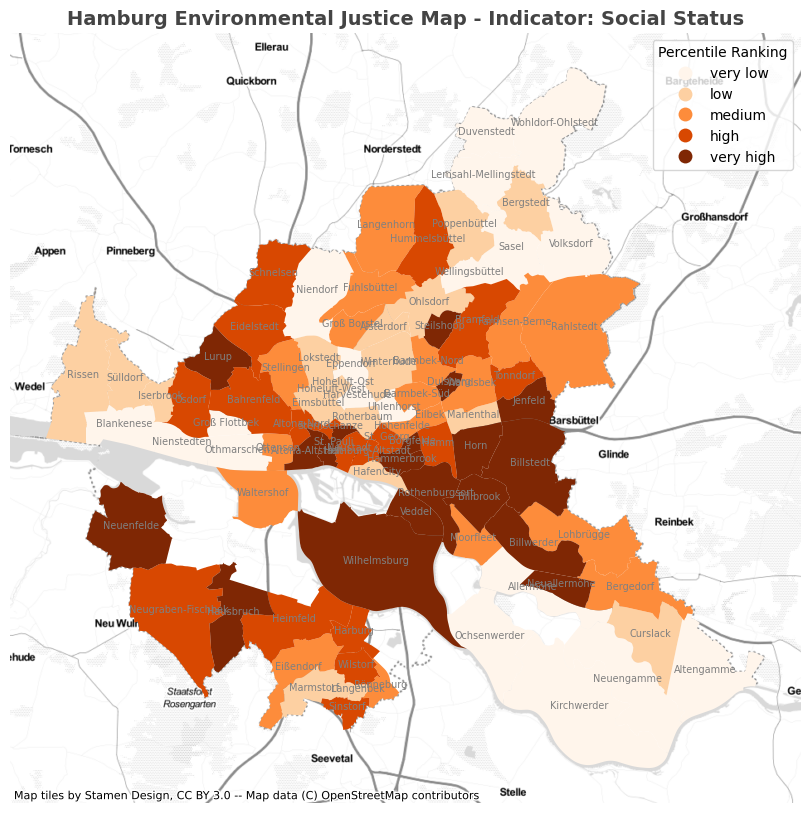

In [61]:
## apply the "plot_stats" function to plot the social status indicator 
plot_stats(admin_socstats,"Hamburg Environmental Justice Map - Indicator: Social Status", "Oranges", "./output/map_social_status.png")

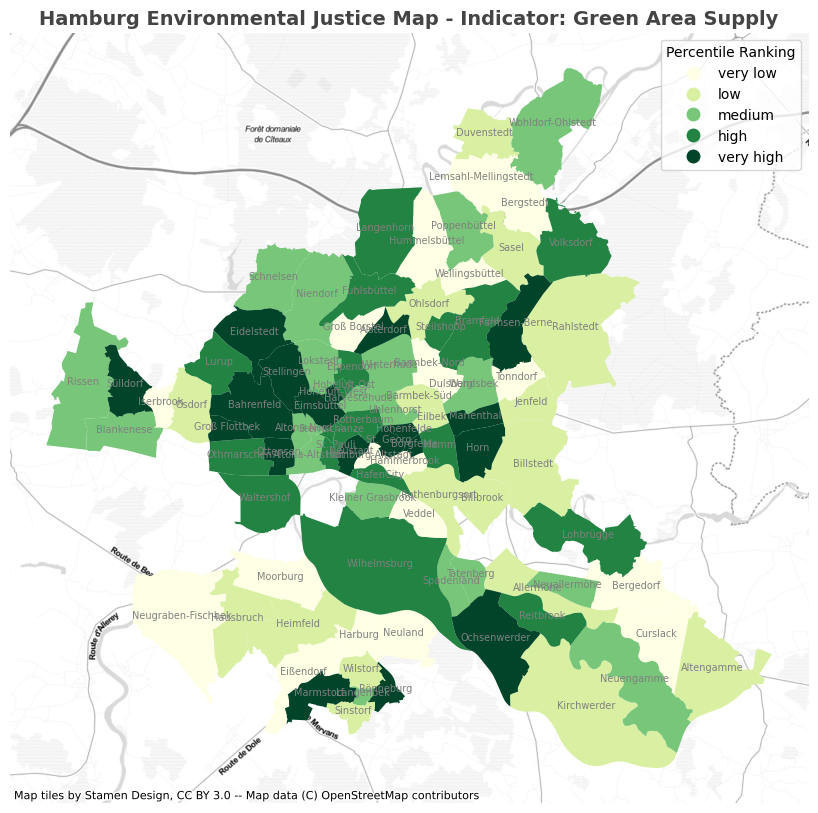

In [62]:
#apply the "plot_stats" function to plot the green supply indicator 
plot_stats(admin_greenstats, "Hamburg Environmental Justice Map - Indicator: Green Area Supply", "YlGn", "./output/map_green_supply.png")

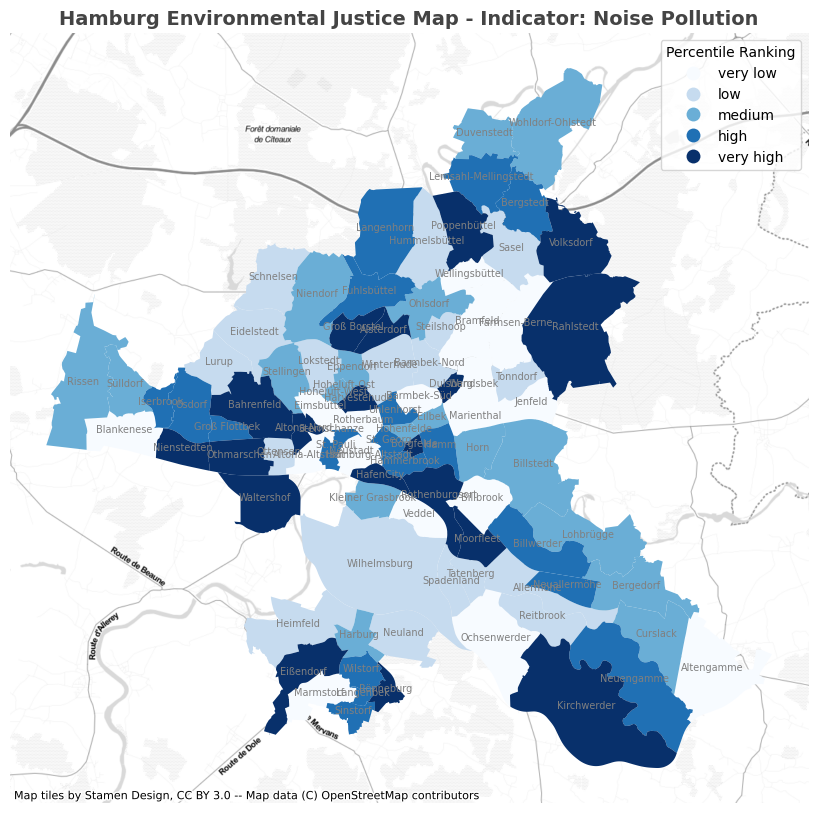

In [63]:
#apply the "plot_stats" function to plot the noise pollution indicator 
plot_stats(noisestats_merged, "Hamburg Environmental Justice Map - Indicator: Noise Pollution", "Blues","./output/map_noise_pollution.png" )

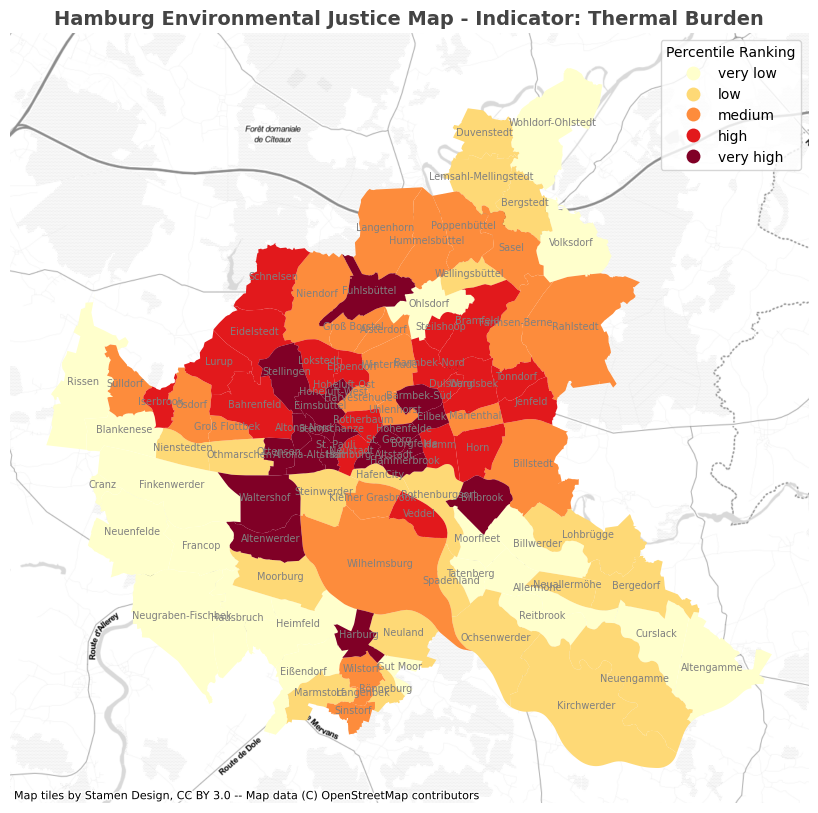

In [64]:
#apply the "plot_stats" function to plot the thermal burden indicator 
plot_stats(temp_bounds, "Hamburg Environmental Justice Map - Indicator: Thermal Burden", "YlOrRd", "./output/map_thermal_burden.png")

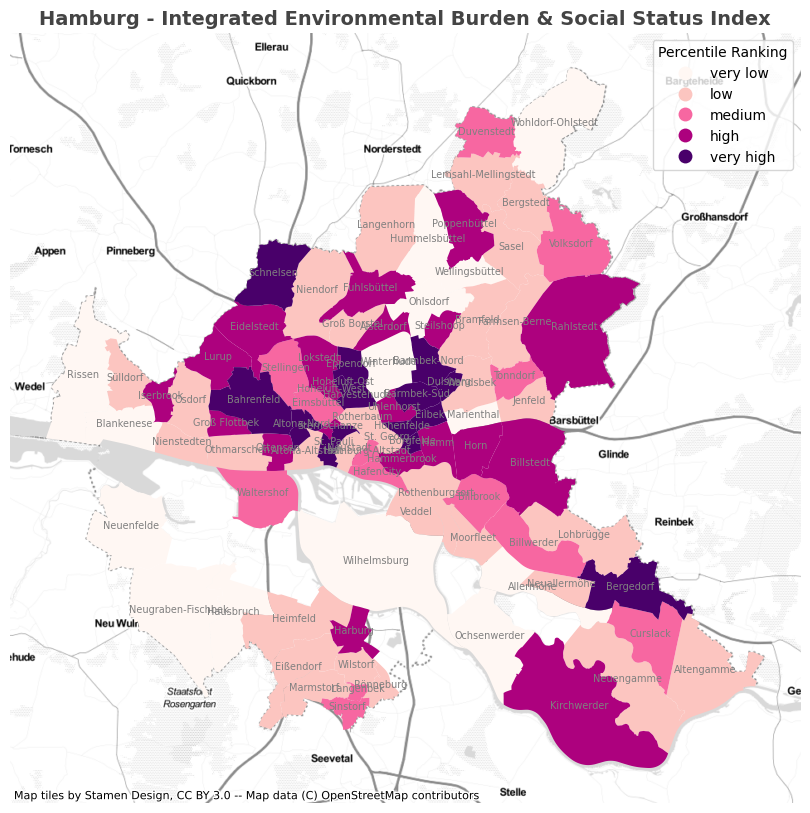

In [65]:
#apply the "plot_stats" function to plot the combined indicator (total of combined indicators)
plot_stats(combined_indicators, "Hamburg - Integrated Environmental Burden & Social Status Index", "RdPu","./output/map_integrated_indicator.png" )

## a) Plots 
Create plots to visualize distribution of cateogrial variables

In [66]:
#counts the number of occurances of each individual indicator per percentile ranking
counts_occurrence = pd.DataFrame({
    'qt_soc_stats': stats_merged['qt_soc_stats'].value_counts(),
    'weighted_area_percentile': stats_merged['weighted_area_percentile'].value_counts(),
    'z_area_per_inhbt_percentile': stats_merged['z_area_per_inhbt_percentile'].value_counts(),
    'MEDIAN_percentile': stats_merged['MEDIAN_percentile'].value_counts(),

})
counts_occurrence

#rename column names to make it nicer for plotting
counts_occurrence=counts_occurrence.rename(columns={"qt_soc_stats":"Social_status","weighted_area_percentile":"Noise Pollution","z_area_per_inhbt_percentile":"Green Area Supply ","MEDIAN_percentile":"Thermal Burden" })


In [67]:
counts_occurrence.head()

,Social_status,Noise Pollution,Green Area Supply,Thermal Burden
0,19,19,16,21
1,18,18,18,20
2,17,19,18,22
3,16,18,16,19
4,14,19,16,21


<Figure size 640x480 with 0 Axes>

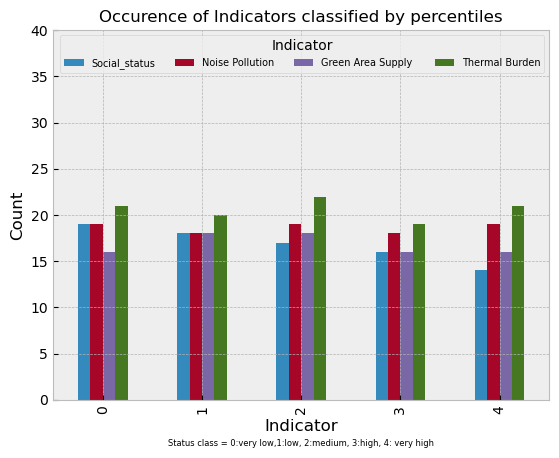

In [68]:
## create plot with  occurances
plt.figure()
plt.style.use('bmh')

counts_occurrence.plot(kind='bar')
plt.ylabel('Count')
plt.xlabel('Indicator')
plt.title('Occurence of Indicators classified by percentiles', fontsize=12)
plt.ylim(0, 40)
plt.legend(title='Indicator', fontsize=7 ,ncols=4)
plt.text( 2, -5, 'Status class = 0:very low,1:low, 2:medium, 3:high, 4: very high', ha='center', fontsize=6)
plt.savefig('./output/occurence_plot.png') #save the plot to the output folder

plt.show()   




In [69]:
#create correlation matrix of individual indicators 
stats_merged.dropna()


corr = stats_merged[['weighted_area_percentile', 'qt_soc_stats','z_area_per_inhbt', 'MEDIAN_percentile','%unemployed', '%social_benefits','env_multiple_burden_percentile' ]].corr().style.background_gradient(cmap="GnBu")


corr

,weighted_area_percentile,qt_soc_stats,z_area_per_inhbt,MEDIAN_percentile,%unemployed,%social_benefits,env_multiple_burden_percentile
weighted_area_percentile,1.000000,-0.069295,-0.208207,-0.139358,-0.104512,-0.019547,0.133635
qt_soc_stats,-0.069295,1.000000,-0.095371,0.417561,0.928307,0.906378,-0.101139
z_area_per_inhbt,-0.208207,-0.095371,1.000000,0.283487,-0.081414,-0.127585,0.149837
MEDIAN_percentile,-0.139358,0.417561,0.283487,1.000000,0.356224,0.208750,-0.019165
%unemployed,-0.104512,0.928307,-0.081414,0.356224,1.000000,0.949350,-0.185722
%social_benefits,-0.019547,0.906378,-0.127585,0.208750,0.949350,1.000000,-0.124352
env_multiple_burden_percentile,0.133635,-0.101139,0.149837,-0.019165,-0.185722,-0.124352,1.000000


<Figure size 1800x1600 with 0 Axes>

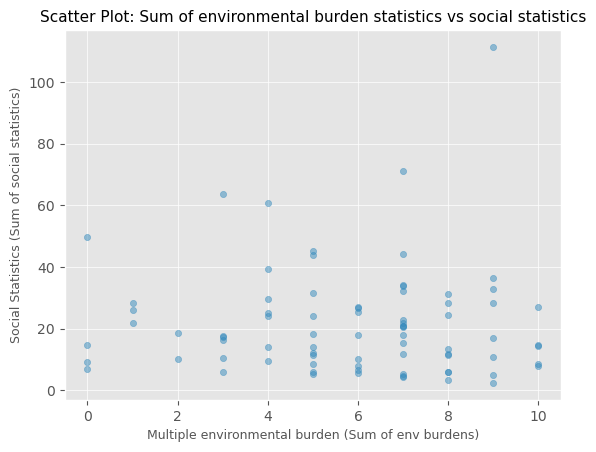

In [70]:
# create a scatter plot of env_multiple burden and social statistics (not classified)

#subset data
stats_merged['sum_socials'] = stats_merged['%social_benefits'] + stats_merged['%unemployed'] + stats_merged['%social_housing']


# create the plot on the two variables
plt.figure(figsize=(18, 16))

plt.style.use('ggplot')

stats_merged.plot.scatter(x='env_multiple_burden', y='sum_socials', alpha=0.5)

# set the labels and title
plt.xlabel('Multiple environmental burden (Sum of env burdens)', fontsize=9)
plt.ylabel('Social Statistics (Sum of social statistics)', fontsize=9)
plt.title('Scatter Plot: Sum of environmental burden statistics vs social statistics', fontsize=11)

plt.savefig('./output/scatter_plot.png', dpi=300, bbox_inches='tight') # save the plot
plt.show()

In [71]:
#outputs a table of the status values
status_counts = stats_merged.groupby('district')[['status_noise', 'status_greens', 'status_soc','env_multiple_burden','combined_indicators']].apply(lambda x: x.apply(pd.Series.value_counts)).unstack().fillna(0)
status_counts.head()


status_noise                                                
                         0.0  1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0  9.0   
district                                                                    
Allermöhe                0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  \
Alsterdorf               0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Altengamme               0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Altona-Altstadt          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Altona-Nord              0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

                 ... combined_indicators                                        
                 ...                10.0 11.0 12.0 13.0 16.0 high  low medium   
district         ...                                                            
Allermöhe        ...                 0.0  0.0  0.0  0.0  0.0  0.0  0.0    0.0  \
Alsterdorf       ...                 0.0  0.0  0.0  0.0  0.0  0.0  0.0    0.0   
Altengamme       ...                 0.0  1.0  0.0  0.0  0.0  0.0  0.0    0.0   
Altona-Altstadt  ...                 0.0  0.0  0.0  0.0  0.0  0.0  0.0    0.0   
Altona-Nord      ...                 0.0  0.0  0.0  1.0  0.0  0.0  0.0    0.0   

                                    
                very high very low  
district                            
Allermöhe             0.0      0.0  
Alsterdorf            0.0      0.0  
Altengamme            0.0      0.0  
Altona-Altstadt       0.0      0.0  
Altona-Nord           0.0      0.0  

[5 rows x 100 columns]

In [72]:
#save the data with statistics to csv
#stats_merged.to_csv("./output/stats_merged.csv")
#noisestats_weighted.to_csv("./output/noise_stats.csv")
#green_stats_zscore.to_csv("./output/green_stats.csv")
#combined_indicators.to_csv("./output/combined_indicators.csv")


##### 

In [73]:
import folium

In [88]:
layer_social ="Social Statistics "
layer_noise = "Noise Pollution Statistics"

In [74]:
combined_indicators_rename=combined_indicators.rename(columns={"district":"District","weighted_area_percentile":"Noise Pollution","z_area_per_inhbt_percentile":"Green Area Supply ","MEDIAN_percentile":"Thermal Burden","env_muliple_burden":"Combined Environmental Burden" , "social_status":"soc", "combined_indicators":"Combined Indicators", "env_multiple_burden_percentile":"Mutliple Environmental Burden", "combined_indicators_percentile":"Integrated Environmental & Social Status Index", "status":"Overall Percentile Ranking","qt_soc_stats":"Social Status"})

In [103]:
m = combined_indicators_rename.explore('Overall Percentile Ranking', cmap='RdPu')


#m.save('map.html')
